In [85]:
using StatsBase, DrWatson, Random

function weight_index(i::Int64,j::Int64,k::Int64; Nx::Int64 = 1, Ny::Int64 = 1)
    return i + Nx*(j-1) + Nx*Ny*(k-1)
end

function new_sim_param(DT::Float64, v0::Float64, DR::Float64, N::Int64, L::Int64, ϕa::Float64, ϕp::Float64; T::Float64 = 0.001, name::String = "test", save_interval::Float64 = 0.001, save_on::Bool = false)
    param::Dict{String, Any} = Dict{String,Any}()
    N₁::Int64,N₂::Int64 = L*N, N
    @pack! param = DT, v0, DR, N, L, ϕa, ϕp, T , name, N₁, N₂, save_interval, save_on
    return param
end

function get_jump_rate(η::Array{Float64, 3}, x₁::Int64, x₂::Int64, y₁::Int64, y₂::Int64, jump::Int64, DT::Float64, v0::Float64, N::Int64, N₁::Int64,N₂::Int64)
    is_valid::Int64 = η[x₁, x₂,1]*(1-η[y₁, y₂,1])
    bias::Float64 = 0.
    if jump == 2 #left
        bias  = -η[x₁, x₂,2]
    elseif jump == 3 #right
        bias  = η[x₁, x₂,2]
    end
    return is_valid*( DT*N^2 + v0*bias*N ) 
end

function initiate_uniform(ϕa::Float64, ϕp::Float64, N₁,N₂)
    η::Array{Float64, 3} = zeros(N₁,N₂,2)
    # x₁, x₂, spin = i, j , k
    w::Weights{Float64, Float64, Vector{Float64}} = weights([ϕa/2, ϕa/2, ϕp, (1 - ϕa - ϕp)])
    particle::Vector{Vector{Int64}} = [ [1,1], [1,-1], [1,0], [0,0]]
    for x₁ in 1:N₁, x₂ in 1:N₂
        η[x₁, x₂, :] = sample(particle,w)
    end
    return η
end

function initiate_weights(η::Array{Float64, 3}, N₁::Int64, N₂::Int64, DT::Float64, v0::Float64, DR::Float64, N::Int64)
    w::Array{Float64, 3} = zeros(N₁,N₂,5)
    jumps::Vector{Tuple{Int64, Int64}} = [(i,j) for i in -1:1:1, j in -1:1:1 if i^2+j^2 ==1 ];
    for x₁ in 1:N₁, x₂ in 1:N₂, jump in 1:4
        local y₁::Int64, y₂::Int64
        # find adjacent site
        y₁, y₂ = ( (x₁, x₂) .+ jumps[jump] .+ (N₁-1, N₂-1) ).% (N₁, N₂) .+ (1,1)
        w[x₁, x₂, jump] =  get_jump_rate(η, x₁, x₂, y₁, y₂, jump, DT, v0, N, N₁,N₂)
    end
    for x₁ in 1:N₁, x₂ in 1:N₂
        local jump::Int64
        jump = 5
        w[x₁, x₂, jump] = DR*η[x₁, x₂,2]^2
    end
    return weights(w)
end

function model_step!(η::Array{Float64, 3}, w::Weights{Float64, Float64, Vector{Float64}}, t::Float64, N₁::Int64, N₂::Int64, DT::Float64, v0::Float64, N::Int64, jumps::Vector{Tuple{Int64,Int64}}) 
    #update total propensity
    prop::Float64 = sum(w)
    #update time
    t += randexp()/prop
    #select jump
    x::Array{Tuple{Int64, Int64, Int64}, 3} = [ (i,j,k) for i in 1:N₁, j in 1:N₂, k in 1:5]
    x₁::Int64, x₂::Int64, jump::Int64 =  sample(x,w)
    if jump == 5
        #execute jump
        η[x₁, x₂, 2] = - η[x₁, x₂, 2]
        #update rates
        for jump in 1:4
            local y₁::Int64, y₂::Int64
            # find adjacent site
            y₁, y₂ = ( (x₁, x₂) .+ jumps[jump] .+ (N₁-1, N₂-1) ).% (N₁, N₂) .+ (1,1)
            w[weight_index(x₁, x₂,jump; Nx =N₁, Ny =N₂)] = get_jump_rate(η, x₁, x₂,y₁, y₂, jump, DT, v0, N, N₁,N₂)
        end
    else
        local y₁::Int64, y₂::Int64
        # find adjacent site
        y₁, y₂ = ( (x₁, x₂) .+ jumps[jump] .+ (N₁-1, N₂-1) ).% (N₁, N₂) .+ (1,1)
        # swap particles
        η[x₁, x₂, :], η[y₁, y₂, :] = η[y₁, y₂, :], η[x₁, x₂, :]
        # set hop rates
        for jump in 1:4
            local z₁::Int64, z₂::Int64 
            #update adjacent sites to x
            z₁, z₂ = ( (x₁, x₂) .+ jumps[jump] .+ (N₁-1, N₂-1) ).% (N₁, N₂) .+ (1,1)
            w[weight_index(x₁, x₂,  jump; Nx =N₁, Ny =N₂)] = 0. # as x is empty
            w[weight_index(z₁, z₂,5-jump; Nx =N₁, Ny =N₂)] = get_jump_rate(η, z₁, z₂, x₁, x₂, 5-jump, DT, v0, N, N₁,N₂)
        
            #update adjacent sites to y
            z₁, z₂ = ( (y₁, y₂) .+ jumps[jump] .+ (N₁-1, N₂-1) ).% (N₁, N₂) .+ (1,1)
            w[weight_index(y₁, y₂,  jump; Nx =N₁, Ny =N₂)] = get_jump_rate(η, y₁, y₂, z₁, z₂,   jump, DT, v0, N, N₁,N₂)
            w[weight_index(z₁, z₂,5-jump; Nx =N₁, Ny =N₂)] = get_jump_rate(η, z₁, z₂, y₁, y₂, 5-jump, DT, v0, N, N₁,N₂)
        end
        # set flip rates
        w[weight_index(x₁, x₂, 5; Nx =N₁, Ny =N₂)] = 0.
        w[weight_index(y₁, y₂, 5; Nx =N₁, Ny =N₂)] = DR*η[y₁, y₂, 2]^2
    end
    return t
end

function sim_save_name(param::Dict{String, Any},t::Float64)
    @unpack DT, v0, DR, N, L, ϕa, ϕp, name, save_interval = param
    s = round(t ; digits = Int64( -log10(save_interval) ÷ 1 ))
    return "/store/DAMTP/jm2386/Active_Lattice/data/pm_sims_raw/$(name)/[DT,v0,DR,N,L,ϕa,ϕp]=$([DT,v0,DR,N,L,ϕa,ϕp])/t=$(s).jld2"
end

function time_series_save_name(param::Dict{String, Any},t::Float64)
    @unpack DT, v0, DR, N, L, ϕa, ϕp, name, save_interval = param
    s = round(t ; digits = Int64( -log10(save_interval) ÷ 1 ))
    return "/store/DAMTP/jm2386/Active_Lattice/data/pm_sims_pro/$(name)/[DT,v0,DR,N,L,ϕa,ϕp]=$([DT,v0,DR,N,L,ϕa,ϕp])/t=$(s).jld2"
end

function run_new_sim(param::Dict{String, Any})
    @unpack DT, v0, DR, N, L, ϕa, ϕp, T , name, N₁, N₂, save_interval, save_on = param
    # configuration
    η::Array{Float64, 3} = initiate_uniform(ϕa, ϕp, N₁, N₂,);
    w::Weights{Float64, Float64, Vector{Float64}} = initiate_weights(η, N₁, N₂, DT, v0, DR,N); 
    t::Float64 = 0.;
    s::Float64 = save_interval
    jumps::Vector{Tuple{Int64, Int64}} = [(i,j) for i in -1:1:1, j in -1:1:1 if i^2+j^2 ==1 ];
    
    #inital save
    if save_on
        filename::String        = sim_save_name(param,t)
        data::Dict{String, Any} = Dict("η" => η, "t" => t)
        safesave(filename,data)
    end

    while t < T
        while t < s
            t = model_step!(η, w, t, N₁, N₂, DT, v0, N, jumps);
        end
        #save snapshot
        if save_on
            filename    = sim_save_name(param,t)
            data        = Dict("η" => η, "t" => t)
            safesave(filename,data)
        end
        s += save_interval
    end
    return η, w, t
end

function run_current_sim(param::Dict{String, Any},dt::Float64, η::Array{Float64, 3}, w::Weights{Float64, Float64, Vector{Float64}}, t::Float64)
    @unpack DT, v0, DR, N, L, ϕa, ϕp , name, N₁, N₂, save_interval, save_on = param
    # configuration
    s::Float64 = t + save_interval
    jumps::Vector{Tuple{Int64, Int64}} = [(i,j) for i in -1:1:1, j in -1:1:1 if i^2+j^2 ==1 ];
    
    #inital save
    if save_on
        filename::String = sim_save_name(param,t)
        data::Dict{String, Any} = Dict("η" => η, "t" => t)
        safesave(filename,data)
    end

    while t < t+dt
        while t < s
            t = model_step!(η, w, t, N₁, N₂, DT, v0, N, jumps);
        end
        #save snapshot
        if save_on
            filename = sim_save_name(param,t)
            data = Dict("η" => η, "t" => t)
            safesave(filename,data)
        end
        s += save_interval
    end
    return η, w, t
end

function load_sim(param::Dict{String, Any},t::Float64)
    filename::String = sim_save_name(param::Dict{String, Any},t::Float64)
    data::Dict{String, Any} = load(filename)
    @unpack η, t = data 
    return η, t
end

function load_and_run_sim(param::Dict{String, Any})
    @unpack DT, v0, DR, N, L, ϕa, ϕp, T , name, N₁, N₂, save_interval, save_on = param
    # configuration
    η::Array{Float64, 3} = initiate_uniform(ϕa, ϕp, N₁, N₂,);
    w::Weights{Float64, Float64, Vector{Float64}} = initiate_weights(η, N₁, N₂, DT, v0, DR,N); 
    t::Float64 = 0.;
    s::Float64 = T;
    loaded::Bool = false
    jumps::Vector{Tuple{Int64, Int64}} = [(i,j) for i in -1:1:1, j in -1:1:1 if i^2+j^2 ==1 ];
    
    while s>0.
        try
            η, t = load_sim(sim_param,s)
            w = initiate_weights(η, N₁, N₂, DT, v0, DR,N);
            loaded = true
            s = -1.
        catch
            loaded = false
            #println("load failed at t = $(s)")
            s += -save_interval
        end
    end

    if loaded
        println("load at t = $(t)")
        s = t + save_interval
        while t < T
            while t < s
                t = model_step!(η, w, t, N₁, N₂, DT, v0, N, jumps);
            end
            #save snapshot
            if save_on
                filename    = sim_save_name(param,t)
                data        = Dict("η" => η, "t" => t)
                safesave(filename,data)
            end
            s += save_interval
        end
    else
        println("all loading failed; running new simulation")
        η, w, t = run_new_sim(param)
    end
    return η, w, t
end

function load_compress_sim(param::Dict{String, Any})
    @unpack DT, v0, DR, N, L, ϕa, ϕp, T , name, N₁, N₂, save_interval, save_on = param
    t_saves::Vector{Float64}            = []
    η_saves::Vector{Array{Float64, 3}}  = []
    data::Dict{String, Any} = Dict()

    try
        try
            filename::String = time_series_save_name(param,T)
            data = load(filename)
        catch
            filename::String = time_series_save_name(param,T-save_interval)
            data= load(filename)
        end
        @unpack t_saves, η_saves = data
        println("fast load")
    catch
        println("full load")
        s = 0.
        t = 0.
        while s<T
            try
                η, t = load_sim(sim_param,s)
                push!(η_saves,η)
                push!(t_saves,t)
                s += save_interval
            catch
                s += save_interval
            end
        end
        if t > 0.
            filename::String = time_series_save_name(param,t)
            data = Dict("η_saves" => η_saves, "t_saves" => t_saves)
            safesave(filename,data)
            println("saved")
        end
    end

    return t_saves, η_saves
end

function local_average(η, ϵ, N, N₁, N₂)
    ρa::Array{Float64,2} = zeros(N₁, N₂)
    ρp::Array{Float64,2} = zeros(N₁, N₂)
    m ::Array{Float64,2} = zeros(N₁, N₂)
    jumps::Vector{Tuple{Int64, Int64}} = [(i,j) for i in -N₁:1:N₁, j in -N₂:1:N₂ if i^2+j^2 ≤ ϵ*N ];
    njumps::Int64 = length(jumps)
    for x₁ in 1:N₁, x₂ in 1:N₂
        for jump in jumps
            local y₁::Int64, y₂::Int64
            # find adjacent site
            y₁, y₂ = ( (x₁, x₂) .+ jump .+ (N₁-1, N₂-1) ).% (N₁, N₂) .+ (1,1)
            ρa[x₁, x₂] += η[y₁, y₂,2]^2
            ρp[x₁, x₂] += η[y₁, y₂,1]^2-η[y₁, y₂,2]^2
            m[x₁, x₂]  += η[y₁, y₂,2]
        end
    end
    return (ρa, ρp, m)./njumps
end

function local_average_1d(η, ϵ, N, N₁, N₂)
    ρa::Vector{Float64} = zeros(N₁)
    ρp::Vector{Float64} = zeros(N₁)
    m ::Vector{Float64} = zeros(N₁)
    jumps::Vector{Tuple{Int64, Int64}} = [(i,j) for i in -N₁:1:N₁, j in -N₂:1:N₂ if i^2+j^2 ≤ ϵ*N ];
    njumps::Int64 = length(jumps)
    for x₁ in 1:N₁, x₂ in 1:N₂
        for jump in jumps
            local y₁::Int64, y₂::Int64
            # find adjacent site
            y₁, y₂ = ( (x₁, x₂) .+ jump .+ (N₁-1, N₂-1) ).% (N₁, N₂) .+ (1,1)
            ρa[x₁] += η[y₁, y₂,2]^2
            ρp[x₁] += η[y₁, y₂,1]^2-η[y₁, y₂,2]^2
            m[x₁]  += η[y₁, y₂,2]
        end
    end
    return (ρa, ρp, m)./(njumps*N₂)
end

function rho_to_rgb(ρa, ρp, m; type = "rho" )
    Nx, Ny = size(ρa)
    rgb_image = ones(Ny, Nx,3)
    if type == "rho"
        rgb_image[:,:,3] = -ρa'[Ny:-1:1,:]  .+1
        rgb_image[:,:,1] = -ρp'[Ny:-1:1,:] .+1
        rgb_image[:,:,2] = -ρa'[Ny:-1:1,:]  -ρp'[Ny:-1:1,:]  .+1
    else
        rgb_image[:,:,1] = map((x ->  max(0,x)), m'[Ny:-1:1,:])
        rgb_image[:,:,2] = map((x -> -min(0,x)), m'[Ny:-1:1,:])
        rgb_image[:,:,3] = -ρa'[Ny:-1:1,:] -ρp'[Ny:-1:1,:] .+1
    end
    return rgb_image
end

rho_to_rgb (generic function with 1 method)

In [86]:
DT, v0, DR, N, L, ϕa, ϕp = (1.0, 7.5, 1.0, 10, 2, 0.5, 0.2);
sim_param = new_sim_param(DT, v0, DR, N, L, ϕa, ϕp; T = 0.04, name = "test", save_interval = 0.001, save_on = true);
t_saves, η_saves = load_compress_sim(sim_param)
t, η = t_saves[end], η_saves[end]

fast load


(0.03916300333568578, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 0.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 0.0 0.0;;; 1.0 0.0 … 1.0 -1.0; 0.0 -1.0 … -1.0 0.0; … ; 0.0 0.0 … -1.0 1.0; -1.0 -1.0 … 0.0 0.0])

In [88]:
@unpack DT, v0, DR, N, L, ϕa, ϕp, T , name, N₁, N₂, save_interval, save_on = sim_param

ϵ = 0.1
ρa, ρp, m = local_average(η, ϵ, N, N₁, N₂)

# ρa, ρp, m = local_average_1d(η, ϵ, N, N₁, N₂)


([0.6 0.6 … 0.6 0.6; 0.4 0.4 … 0.6 0.6; … ; 0.6 0.4 … 0.6 0.4; 0.6 0.4 … 0.6 0.6], [0.4 0.2 … 0.2 0.0; 0.2 0.4 … 0.0 0.2; … ; 0.4 0.4 … 0.0 0.2; 0.2 0.4 … 0.0 0.0], [-0.2 -0.2 … -0.2 0.2; 0.0 0.0 … -0.2 -0.6; … ; -0.2 0.0 … 0.2 0.0; -0.2 -0.4 … -0.2 -0.2])

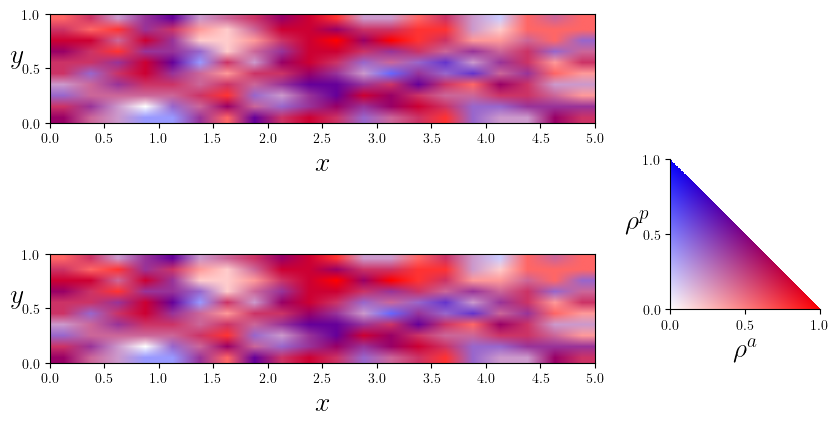

In [161]:
L = 5

rgb_image = rho_to_rgb(ρa, ρp, m; type = "rho" );

using PyPlot
PyPlot.close("all")
rc("text", usetex=true)
fig, axs = plt.subplots(2, 1, figsize=(10,5))

for ax in axs
    ax.imshow(rgb_image; extent = [0,L,0,1], interpolation = "bilinear")
    ax.get_xaxis().set_ticks(0:0.5:L)
    ax.get_yaxis().set_ticks(0:0.5:1)
    ax.set_xlabel(L"x", fontsize = 20)
    ax.set_ylabel(L"y",fontsize = 20, rotation = 0)
end

fig.tight_layout()

# add colour bars
fig.subplots_adjust(right=0.6)
cbar_ax = fig.add_axes([0.65, 0.3, 0.2, 0.3])

ax = cbar_ax

Δx = 0.001
cbar_ρa = [ x*(x+y≤ 1) for x in Δx:Δx:1, y in Δx:Δx:1 ] 
cbar_ρp = [ y*(x+y≤1) for x in Δx:Δx:1, y in Δx:Δx:1 ] 
cbar_m  = [ 0 for x in Δx:Δx:1, y in Δx:Δx:1 ] 

rgb_image = rho_to_rgb(cbar_ρa, cbar_ρp, cbar_m; type = "rho" );

ax.imshow(rgb_image; extent = [0,1,0,1])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.get_xaxis().set_ticks(0:0.5:1)
    ax.get_yaxis().set_ticks(0:0.5:1)
    ax.set_xlabel(L"\rho^a", fontsize = 20)
    ax.set_ylabel(L"\rho^p",fontsize = 20, rotation = 0)
display(fig)


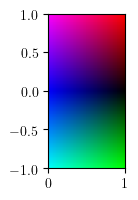

In [57]:
using PyPlot
PyPlot.close("all")
rc("text", usetex=true)
fig, ax = plt.subplots(1, 1, figsize=(2,2))

cbar_ρa = [ x for x in 0.01:0.01:1, y in (-1):0.01:1 ] 
cbar_ρp = [ 0 for x in 0.01:0.01:1, y in (-1):0.01:1 ] 
cbar_m  = [ y for x in 0.01:0.01:1, y in (-1):0.01:1 ] 

rgb_image = rho_to_rgb(cbar_ρa, cbar_ρp, cbar_m; type = "mag" );

ax.imshow(rgb_image; extent = [0,1,-1,1])
display(fig)